In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

import folium

from geopy.geocoders import Nominatim

*Заргрузим очищенные данные из датафрейма*

In [64]:
data = pd.read_csv(r'C:\Data\Pet Parser HH\df_2_with_tags.csv', index_col= 0)
data.head(5)

,field,salary,experience,company,address,tags,job type,job hours,sql,python,...,анализ бизнес показателей,tableau,data science,pandas,oracle,pytorch,nlp,постановка задач разработчикам,atlassian jira,a/b тесты
0,Data Analyst,0.0,1–3 года,ООО PepsiCo,Москва,машинное обучение python прогнозирование спрос...,полная занятость,полный день,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Data Analyst,52500.0,не требуется,ООО ТЕХНОТРЕЙД,Ростов,анализ данных составление отчетности мониторин...,полная занятость,полный день,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Data Engineer,0.0,1–3 года,ГКУ «Центр цифровой трансформации РТ»,Казань,NaN,полная занятость,полный день,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Data Analyst,0.0,1–3 года,ТОО МИКРОФИНАНСОВАЯ ОРГАНИЗАЦИЯ SOFI FINANCE (...,Алматы,sql базы данных аналитика аналитическое мышлен...,полная занятость,полный день,1,0,...,1,0,0,0,0,0,0,0,0,0
4,Data Analyst,90000.0,1–3 года,DNS Головной офис,Владивосток,грамотная речь деловая переписка мониторинг ры...,полная занятость,полный день,0,0,...,1,0,0,0,0,0,0,0,0,0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588 entries, 0 to 2587
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   field                                2588 non-null   object 
 1   salary                               2588 non-null   float64
 2   experience                           2588 non-null   object 
 3   company                              2588 non-null   object 
 4   address                              2544 non-null   object 
 5   tags                                 1765 non-null   object 
 6   job type                             2588 non-null   object 
 7   job hours                            2588 non-null   object 
 8   sql                                  2588 non-null   int64  
 9   python                               2588 non-null   int64  
 10  анализ данных                        2588 non-null   int64  
 11  аналитическое мышление        

*Посмотрим общую статистику по типу вакансий*

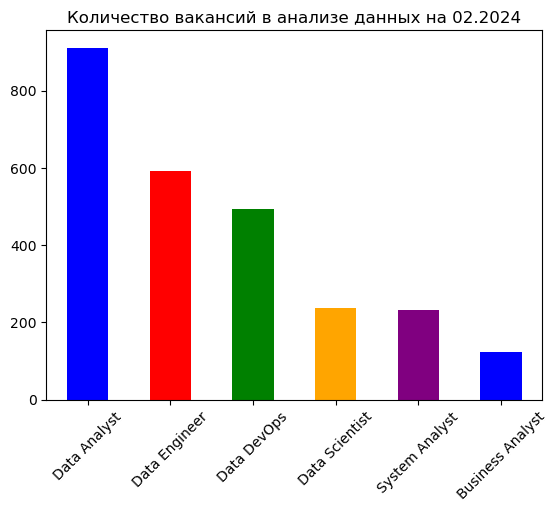

In [66]:
data['field'].value_counts().plot(kind='bar', color=['blue', 'red', 'green', 'orange', 'purple'])
plt.xticks(rotation=45)
plt.title ('Количество вакансий в анализе данных на 02.2024')
plt.show()

**Ранжирования вакансии в анализе данных**
- Дата аналитик (но здесь не всегда отделяется от дата инженера и дата сайентиста)
- Дата Инженер
- Дата Сайентист
Далее по мере убывания идут 
- Системный аналитик
- Бизнес Аналитик


*Посмотрим географию распределения вакансий*

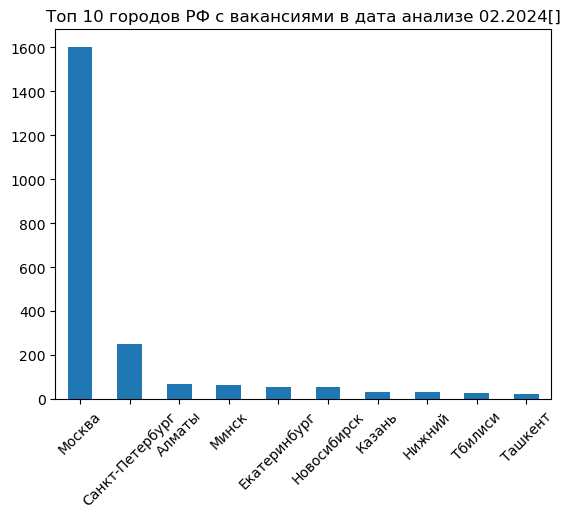

In [67]:
data['address'].value_counts()[:10].plot(kind='bar')
plt.xticks(rotation=45)
plt.title ('Топ 10 городов РФ с вакансиями в дата анализе 02.2024[]')
plt.show()

**Города с наибольшим количеством вакансий - Москва, Санкт-Петербург**

Следует отменить количество вакансий в городах Алматы, Минске, Тбилиси, Ташкенте.

Построим интерактивную карту с данными количества вакансий по городам

In [207]:
# Подсчет количества упоминаний каждого города
city_counts = data['address'].value_counts()

#добавление в локации геоданных
geolocator = Nominatim(user_agent="my_geocoder")
def geocode(city):
    location = geolocator.geocode(city)
    return (location.latitude, location.longitude)


# создание карты с центром в г.Москва
m = folium.Map(location=[55.7558, 37.6176], zoom_start=5)

# добавление маркеров на карту с количеством вакансий по локации
for city, count in city_counts.items():
    folium.Marker(geocode(city), popup=f'{city}: {count}').add_to(m)

m


In [211]:
#сохраним карту
m.save(r"C:\Data\Pet Parser HH\vacancies_map.html")

*Посмотрим требования по рабочему времени для вакансий*

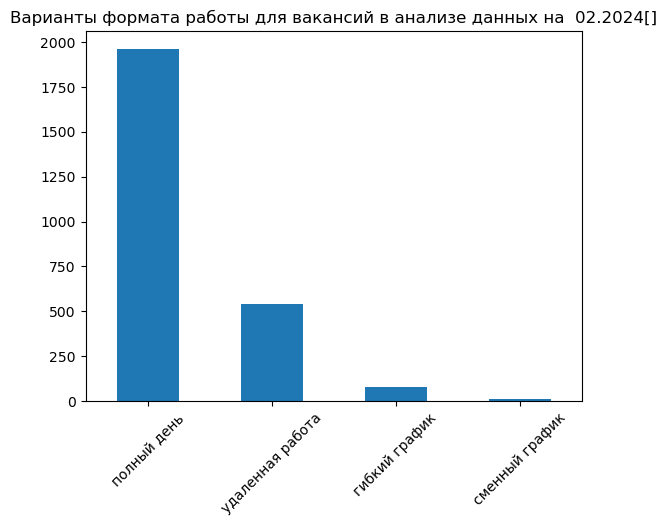

In [68]:
data['job hours'].value_counts().plot(kind='bar')#данный тег не всегда информативен, так как работодатель не всегда указывает эту позицию корректно
plt.xticks(rotation=45)
plt.title ('Варианты формата работы для вакансий в анализе данных на  02.2024[]')
plt.show()

**Основные требования - полный рабочий день(но данные не совсем полные, в тексте вакансии идет более полной описание по графику работы, как правило)**

*Изучим данные по зарплатам*

In [69]:
data['salary'].describe()#посмотрм описательную статистику по зарплатам

count      2588.000000
mean      34235.605989
std       84220.191777
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      900000.000000
Name: salary, dtype: float64

**По всем вакансиям - средняя зарплата 34 235тыс руб, но ниже данные корректируем, так как много вакансий не публикуют зарплату**

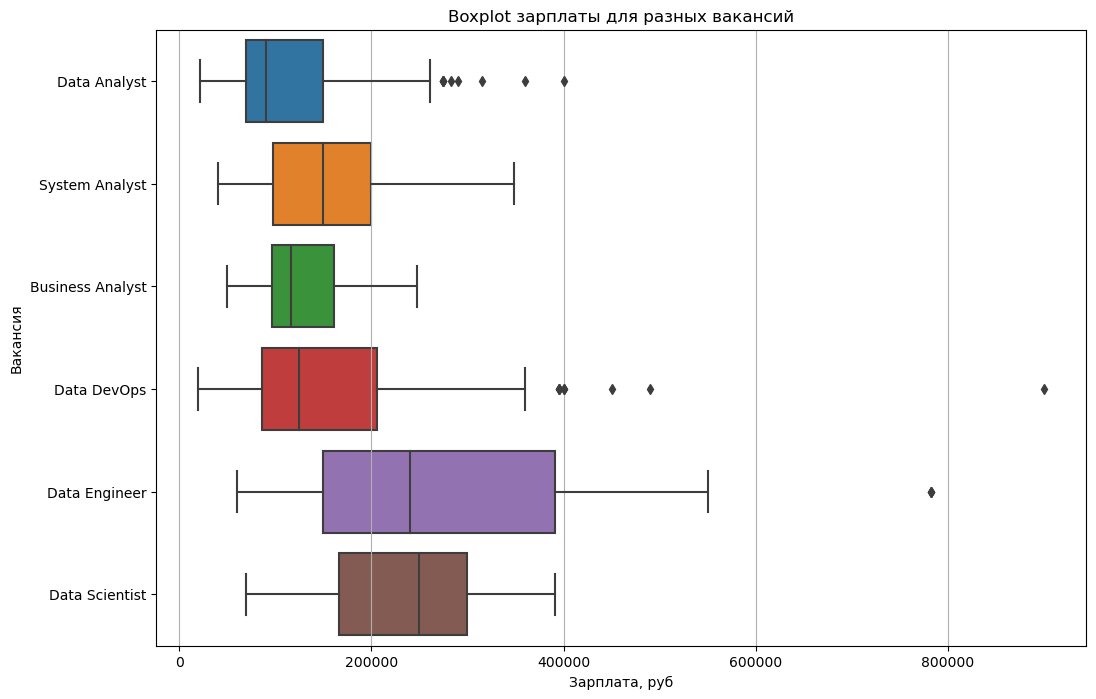

In [70]:
# удаление строк с нулевыми значениями в столбце 'salary'
data_without_zeros = data.query('salary != 0').reset_index()

# создание графика
plt.figure(figsize=(12, 8))
sns.boxplot(x='salary', y='field', data=data_without_zeros)
plt.xlabel('Зарплата, руб')
plt.ylabel('Вакансия')
plt.title('Boxplot зарплаты для разных вакансий')

# Отображение графика
plt.grid(axis='x')
plt.show()



**Общий график боксплотов для всех вакансий явно определяет зарплатные тенденции для всех видов деятельности**

- Самые высокие запрлаты предлагают инженерам и разработчикам в сфере данных, затем идут дата сайентисты, системные аналитики. 
- Для дата аналитиков минимальный порог ниже, но размах тоже широкий. Это объяснимо разными уровнями требований к скиллами.

In [79]:
#теперь посмотрим описательную статситику по зарплате для всех вакансий
data_without_zeros['salary'].describe()

count       553.000000
mean     160220.159675
std      114106.838628
min       20000.000000
25%       80000.000000
50%      125000.000000
75%      202500.000000
max      900000.000000
Name: salary, dtype: float64

**Более точная описательная статистика на данных без нулевых строк**

- Минимальная заплата 20 000 рублей. 
- Максимальная зарплата 900 000 рублей
- Средняя зарплата 160 тыс рублей, медианная 125 00 рублей.

In [80]:
#медианное значение по зарплате для всех вакансий
data_without_zeros['salary'].median()

125000.0

*Посмотрми какая же компания предлагает зарплату в 900 000 рублей*

In [83]:
data_without_zeros['salary'].argmax()

535

In [84]:
data_without_zeros.iloc[535] #не забываем что эти данные могут быть опечаткой.

index                                                                               2436
field                                                                        Data DevOps
salary                                                                          900000.0
experience                                                                       3–6 лет
company                                                                       the_covert
address                                                                          Тбилиси
tags                                   sql python etl работа с базами данных power bi...
job type                                                                полная занятость
job hours                                                                    полный день
sql                                                                                    1
python                                                                                 1
анализ данных        

*Чтобы быть обьективными посмотрим второй по величене показатель по запрплате и информацию по этой вакансии*

In [89]:
data_without_zeros['salary'].nlargest(2).idxmin()

467

In [90]:
data_without_zeros.iloc[467]

index                                                    2125
field                                           Data Engineer
salary                                               783000.0
experience                                            3–6 лет
company                                Social Discovery Group
address                                               Тбилиси
tags                                              nlp pytorch
job type                                     полная занятость
job hours                                         полный день
sql                                                         0
python                                                      0
анализ данных                                               0
аналитическое мышление                                      0
postgresql                                                  0
etl                                                         0
ms excel                                                    0
аналитик

**Посмотрим топ 10 вакансий с данными компаний и странами**

In [103]:
top_10_salaries = data_without_zeros.nlargest(10, 'salary')
top_10_salaries[['field', 'company', 'address', 'salary', 'tags']]

,field,company,address,salary,tags
535,Data DevOps,the_covert,Тбилиси,900000.0,sql python etl работа с базами данных power bi...
467,Data Engineer,Social Discovery Group,Тбилиси,783000.0,nlp pytorch
468,Data Engineer,Social Discovery Group,Сербия,783000.0,nlp pytorch
469,Data Engineer,Social Discovery Group,Алматы,783000.0,nlp pytorch
488,Data Engineer,ООО Mindbox,Москва,550000.0,python pyspark airflow kafka deltalake k8s dremio
455,Data Engineer,UAE based software development company,Москва,490000.0,ai ml machine learning python docker unix англ...
532,Data DevOps,UAE based software development company,Москва,490000.0,typescript node.js langchain python ai ml dock...
510,Data Engineer,the_covert,Тбилиси,469800.0,deep learning pytorch mathematical statistics ...
247,Data Engineer,Skanestas Investments Limited,Кипр,450000.0,python sql nosql spark kafka airflow hadoop st...
365,Data Engineer,Кадровое агентство Алексея Сухорукова,Новосибирск,450000.0,clickhouse kafka etl dwh airflow


*Антиподом посмотрим топ- 5 компаний с минимальными предложениями*

In [104]:
bottom_10_salaries = data_without_zeros.nsmallest(10, 'salary')
bottom_10_salaries[['field', 'company', 'address', 'salary', 'tags']]

,field,company,address,salary,tags
345,Data DevOps,Инженеры продаж,Красноярск,20000.0,seo обучение и развитие google docs составлени...
183,Data Analyst,Киселевский филиал ФГКУ УВО ВНГ России по Кеме...,NaN,21750.0,NaN
223,Data Analyst,Новочебоксарский химико-механический техникум ...,Новочебоксарск,21750.0,ms powerpoint пользователь пк ms visio грамотн...
545,Data DevOps,OptimumPrice.ru,NaN,30000.0,python mongodb linux fastapi scrapy scikit-lea...
73,Data Analyst,ИП Варфоломеев Алексей Сергеевич,Ростов,34800.0,анализ финансовых показателей финансовый контр...
23,Data Analyst,АО Союзпечать-Алтай,Барнаул,35000.0,1с работа с базами данных ms excel
130,Data Analyst,ИП Лазарева Светлана Евгеньевна,Москва,35000.0,исполнение личных поручений руководителя работ...
328,Data DevOps,ТОО QB Solutions,Астана,35000.0,power bi figma zoom css ms excel html google d...
112,Data Analyst,ООО КОНТИНЕНТ,Красноярск,36018.0,excel деловая переписка
59,Data Analyst,ООО Премьер-Пласт,NaN,36975.0,1с: торговля формирование бюджета производстве...


*Учитывая, что выше вакансий из других стран, попробуем сгруппировать вакансии по городом и зарплатам и посмотрим результаты


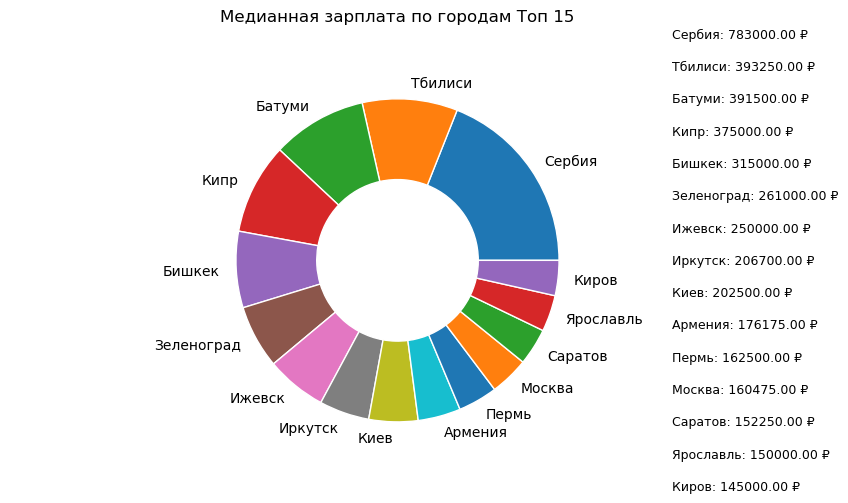

In [136]:
salary_per_city = data_without_zeros.groupby('address')['salary'].median().sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
plt.pie([1], colors='white', radius=1.3)
plt.pie(salary_per_city, labels=salary_per_city.index, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'))
plt.title('Медианная зарплата по городам Топ 15')

# добавляем подписи с медианной зарплатой для каждого города
for i, city in enumerate(salary_per_city.index):
    plt.text(1.7, 1.4 - i*0.2, f'{city}: {salary_per_city[city]:.2f} ₽', ha='left', va='center', fontsize=9)

plt.axis('equal')
plt.show()



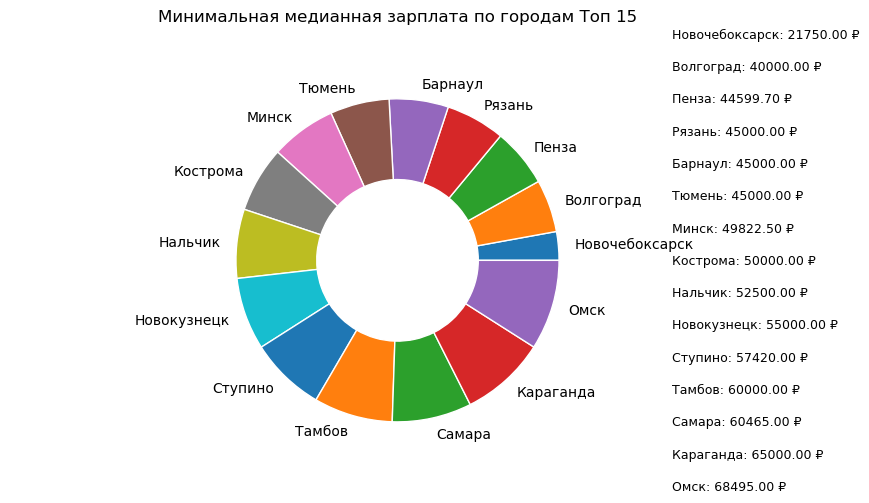

In [149]:
#посмотрим минимальные медианные зарплаты по регионам 
salary_per_city_min = data_without_zeros.groupby('address')['salary'].median().sort_values(ascending=True)[:15]

plt.figure(figsize=(10, 6))
plt.pie([1], colors='white', radius=1.3)
plt.pie(salary_per_city_min, labels=salary_per_city_min.index, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'))
plt.title('Минимальная медианная зарплата по городам Топ 15')

# добавляем подписи с медианной зарплатой для каждого города
for i, city in enumerate(salary_per_city_min.index):
    plt.text(1.7, 1.4 - i*0.2, f'{city}: {salary_per_city_min[city]:.2f} ₽', ha='left', va='center', fontsize=9)

plt.axis('equal')
plt.show()

*Аналогично, посмотрим зарплаты по сферам и медианные зарплаты*

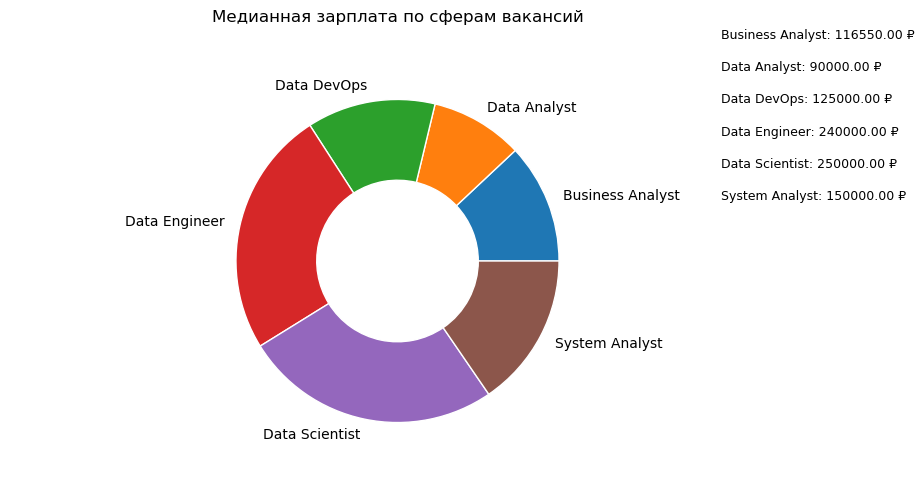

In [147]:
salary_per_field = data_without_zeros.groupby('field')['salary'].median()

plt.figure(figsize=(10, 6))

plt.pie([1],colors='white', radius=1.3)
plt.pie(salary_per_field, labels=salary_per_field.index, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'))
plt.title('Медианная зарплата по сферам вакансий')

# добавляем подписи с медианной зарплатой для каждой сферы
for i, field in enumerate(salary_per_field.index):
    plt.text(2.0, 1.4 - i*0.2, f'{field}: {salary_per_field[field]:.2f} ₽', ha='left', va='center', fontsize=9)

plt.axis('equal')
plt.show()

*Для полного анализа построим сводную таблицу по сферам, городам и медианной зарплате*

In [152]:
pivot_table = data_without_zeros.pivot_table(index='field', columns='address', values='salary', aggfunc='median')
pivot_table = pivot_table.fillna('no data')
pivot_table

address,Алматы,Армения,Астана,Балашиха,Барнаул,Батуми,Бердск,Бишкек,Благовещенск,Бронницы,...,Ташкент,Тбилиси,Томск,Тула,Тюмень,Уфа,Хабаровск,Химки,Челябинск,Ярославль
field,,,,,,,,,,,,,,,,,,,,,
Business Analyst,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
Data Analyst,92500.0,no data,78937.5,69600.0,35000.0,no data,no data,no data,no data,no data,...,93600.0,254475.0,50000.0,no data,45000.0,no data,75500.0,92500.0,80000.0,no data
Data DevOps,247500.0,274050.0,107500.0,no data,77000.0,no data,100000.0,315000.0,78300.0,78300.0,...,360180.0,334525.0,no data,no data,no data,125000.0,no data,no data,45000.0,150000.0
Data Engineer,139200.0,78300.0,125000.0,no data,no data,391500.0,no data,no data,no data,no data,...,198000.0,454140.0,110000.0,no data,no data,60000.0,no data,no data,200000.0,no data
Data Scientist,no data,no data,174000.0,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
System Analyst,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,101790.0,no data,108750.0,no data,80000.0,no data,no data,no data,no data


*Проанализируем теги-скиллы к вакансиям*

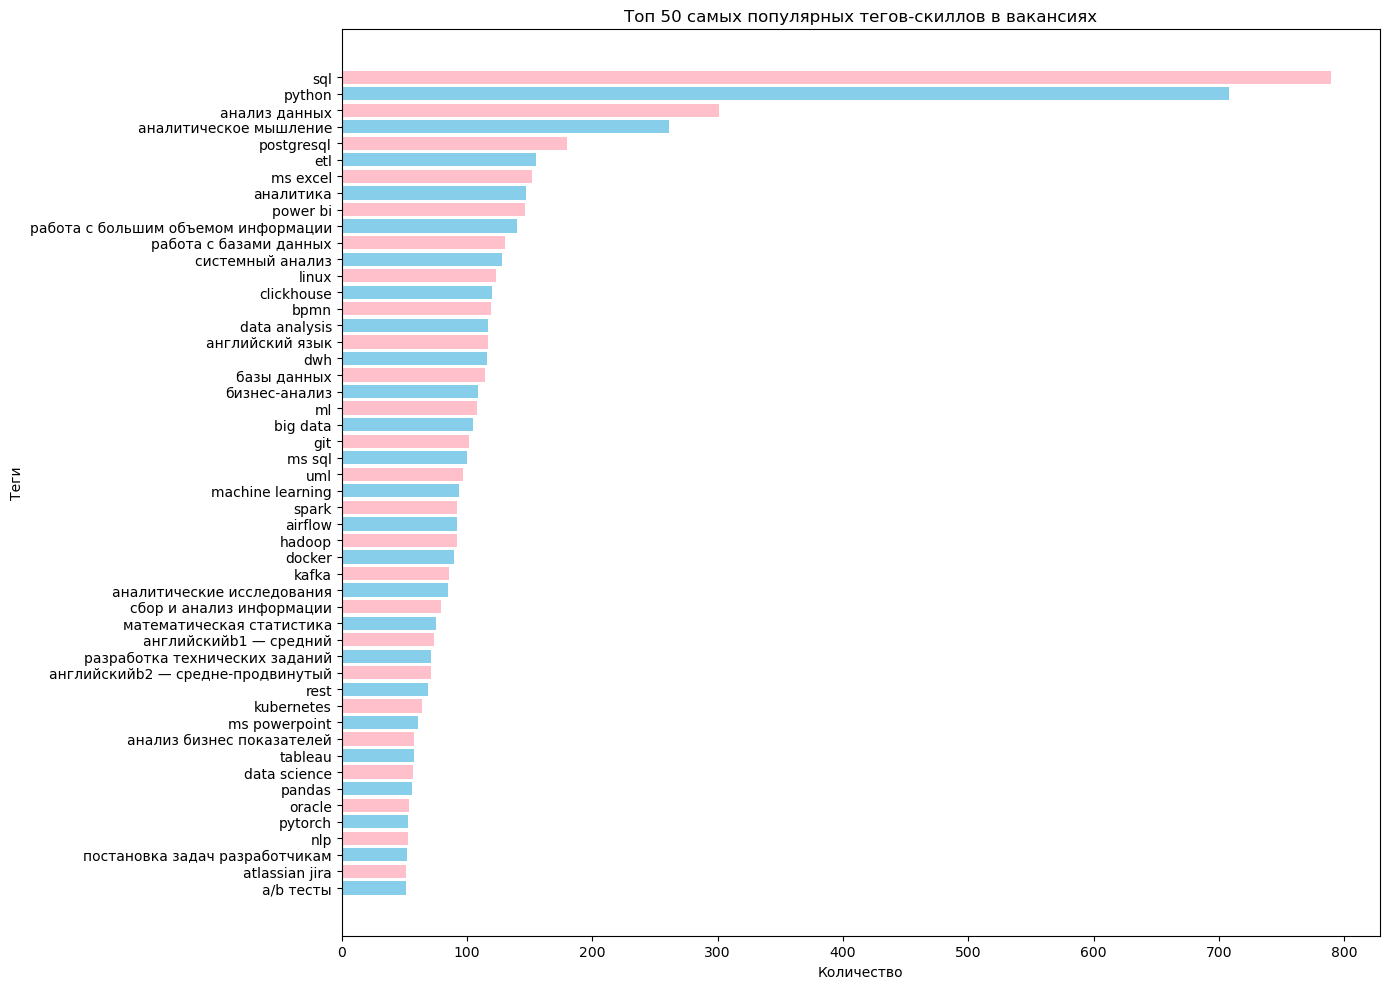

In [153]:
# загрузка данных из файла 'tags_counter.json'
with open('tags_counter.json', 'r') as file:
    tags_counter = json.load(file)

# cортировка словаря по значению (по количеству)
sorted_tags_counter = dict(sorted(tags_counter.items(), key=lambda x: x[1], reverse=True))

# получение первых 50 самых популярных тегов
top_50_tags = list(sorted_tags_counter.keys())[:50][::-1]
top_50_counts = [sorted_tags_counter[tag] for tag in top_50_tags]


# Создание барплота для топ 50 тегов
plt.figure(figsize=(14, 10))
plt.barh(top_50_tags, top_50_counts, color=['skyblue', 'pink'])
plt.ylabel('Теги')
plt.xlabel('Количество')
plt.title('Топ 50 самых популярных тегов-скиллов в вакансиях')
plt.tight_layout()
plt.show()


In [154]:
data.columns

Index(['field', 'salary', 'experience', 'company', 'address', 'tags',
       'job type', 'job hours', 'sql', 'python', 'анализ данных',
       'аналитическое мышление', 'postgresql', 'etl', 'ms excel', 'аналитика',
       'power bi', 'работа с большим объемом информации',
       'работа с базами данных', 'системный анализ', 'linux', 'clickhouse',
       'bpmn', 'data analysis', 'английский язык', 'dwh', 'базы данных',
       'бизнес-анализ', 'ml', 'big data', 'git', 'ms sql', 'uml',
       'machine learning', 'spark', 'airflow', 'hadoop', 'docker', 'kafka',
       'аналитические исследования', 'сбор и анализ информации',
       'математическая статистика', 'английскийb1 — средний',
       'разработка технических заданий', 'английскийb2 — средне-продвинутый',
       'rest', 'kubernetes', 'ms powerpoint', 'анализ бизнес показателей',
       'tableau', 'data science', 'pandas', 'oracle', 'pytorch', 'nlp',
       'постановка задач разработчикам', 'atlassian jira', 'a/b тесты'],
      dtype

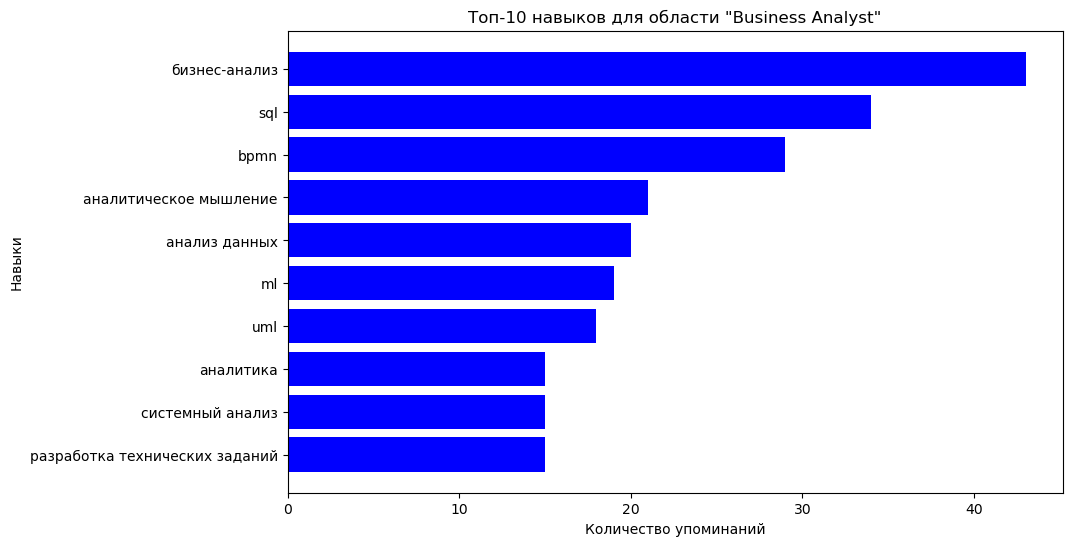

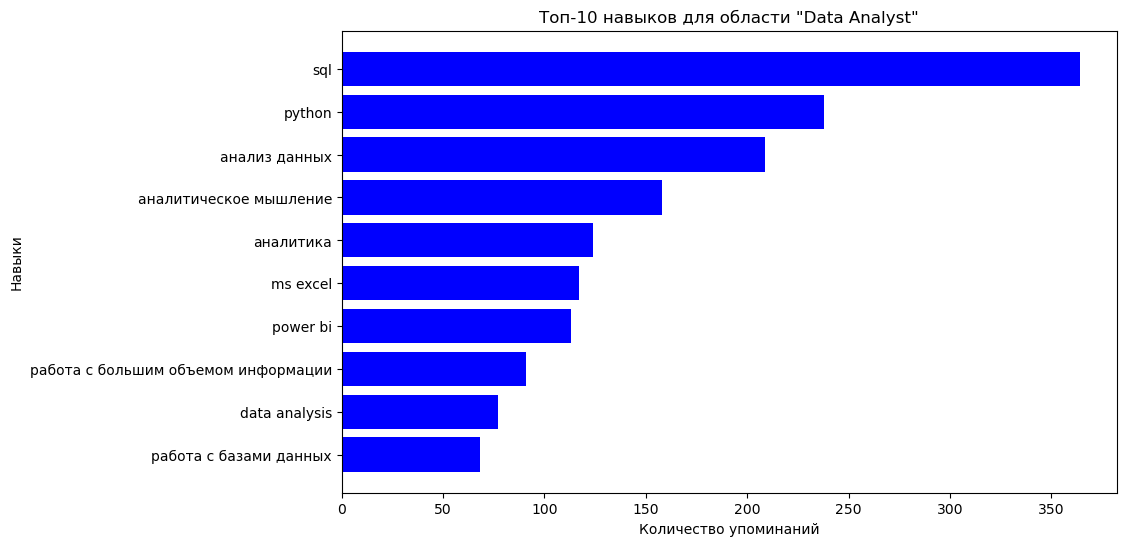

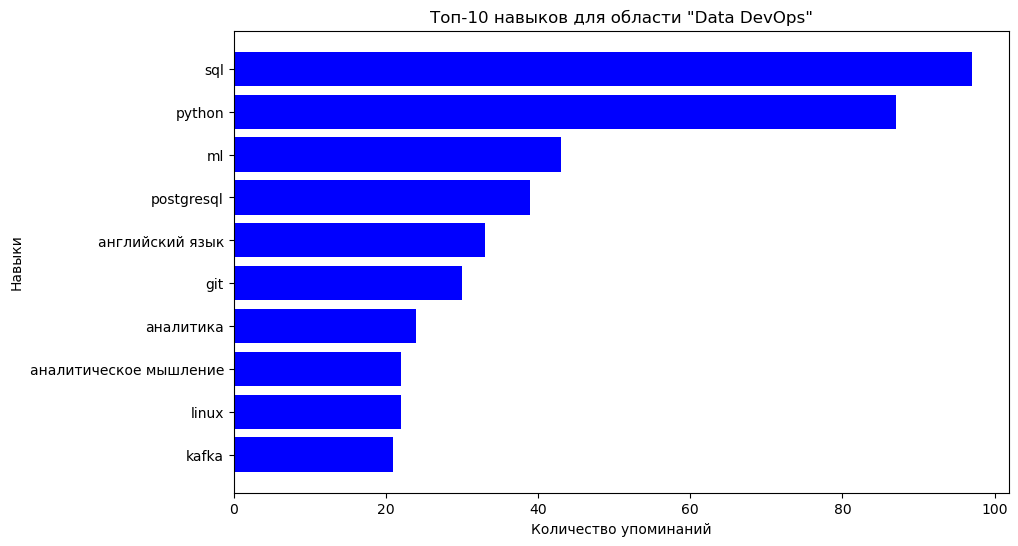

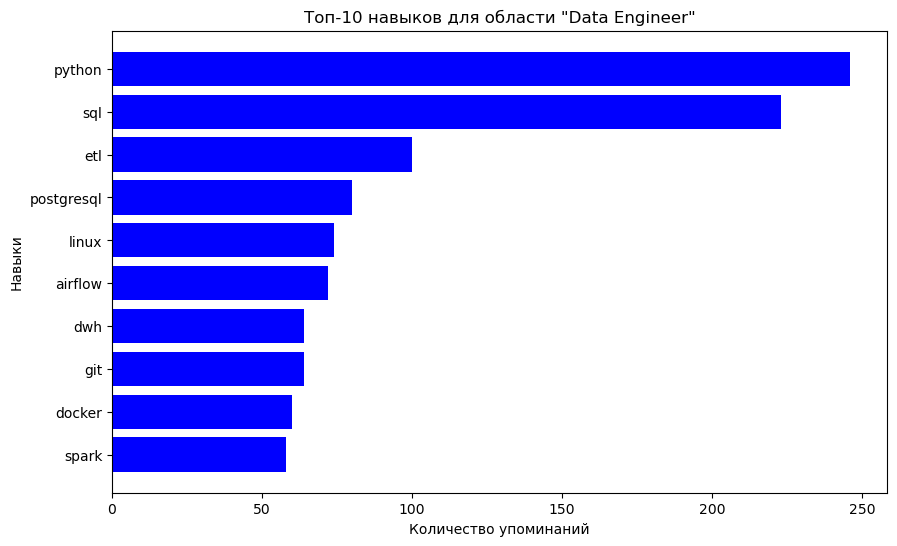

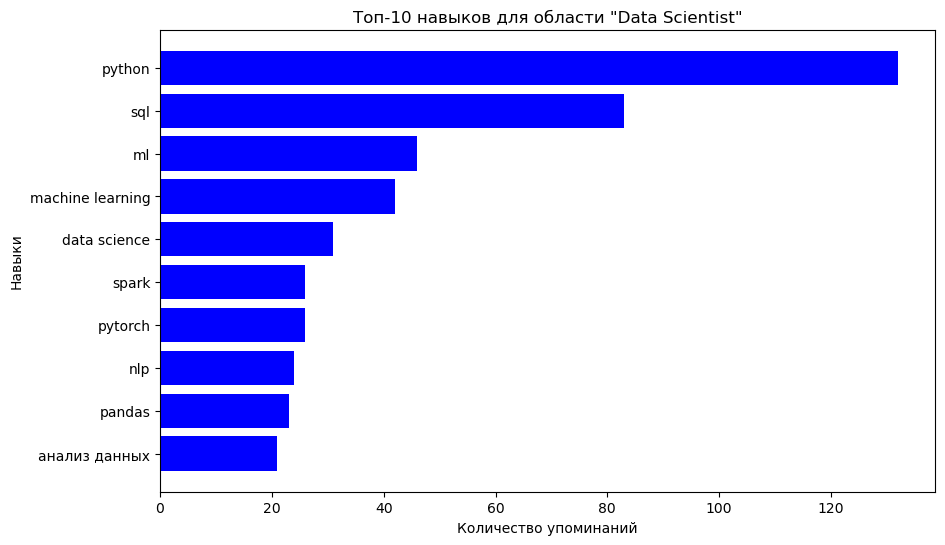

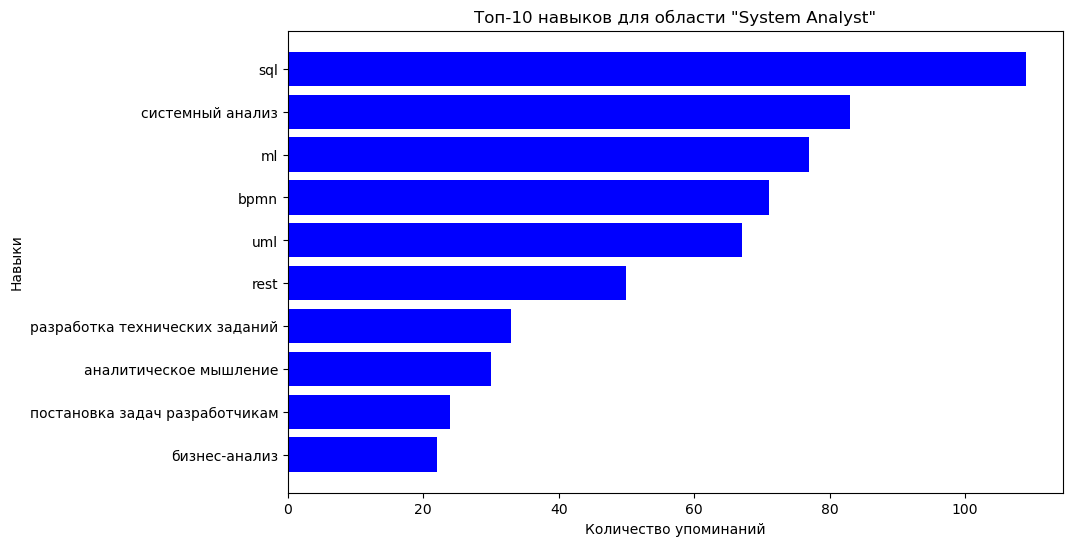

In [165]:
#посмотрим топ 10 скиллов для каждой вакансии 
data_no_salary = data.drop('salary', axis =1)
skills_count = data_no_salary.groupby('field').sum(numeric_only=True)

# Получение топ-10 наиболее часто встречающихся скиллов для каждой области
top_skills = {}
for field in skills_count.index:
    top_skills[field] = skills_count.loc[field].nlargest(10).to_dict()

top_skills

for field, skills in top_skills.items():
    plt.figure(figsize=(10, 6))
    plt.barh(list(skills.keys()), list(skills.values()), color='blue')
    plt.xlabel('Количество упоминаний')
    plt.ylabel('Навыки')
    plt.title(f'Топ-10 навыков для области "{field}"')
    plt.gca().invert_yaxis()  # Инвертируем ось y для отображения наиболее частых навыков сверху
    plt.show()

In [213]:
#оценим так же требования по опыту, часам работы, графику
data.describe(include= 'object')

,field,experience,company,address,tags,job type,job hours
count,2588,2588,2588,2544,1765,2588,2588
unique,6,4,1226,93,1522,4,4
top,Data Analyst,3–6 лет,Сбер для экспертов,Москва,sql python,полная занятость,полный день
freq,911,1192,151,1601,15,2534,1962


Таким образом, получаем общую картинку вакансий 
- топ вакансия Дата Аналитик
- с опытом 3-6 лет 
- Крупный работодататель на HH Сбер (на парсинг 02.2024)
- основные скиллы Python Sql
- Полная занятость на полный день